## 📌 考察と工夫

### 🔍 考察：モデル性能とデータ特性の関係

本研究では、スマートリングおよび赤外線アレイセンサから得られた体温データ、および室温・アンケート情報を用いて、主観的な「適温」を予測するモデルを構築しました。  
実験の結果LSTM単体モデルが最も高精度（R² ≒ 0.9）であり、特に時系列的な温度変化を踏まえた予測が有効であることが示されました。

一方で、**XGBoostやLSTM+XGBoostのハイブリッドモデルは精度がやや劣る結果**となりました。これには以下の要因が関係していると考えられます：

- 訓練データに含まれない温度パターンが検証データに存在していたため、静的特徴量ベースのモデルでは汎化が困難
- 全体のデータの各サンプル数が384件と限られていたため、複雑なモデルでは過学習や未学習の傾向が見られた
- ハイブリッドモデルでは、LSTMの中間特徴がXGBoostで有効活用されず、むしろ誤差が蓄積される傾向が見られた

---

### 🛠️ 工夫した点

本研究では、データの少なさや過学習のリスクを意識しつつ、予測性能を高めるために以下の工夫を行いました。

#### 1. 📈 過学習を抑えながらのデータ拡張

- 元のセンサデータは384件と少数であるため、モデルの学習を安定させる目的で、**時系列的な情報**や**統計量**を導入
- 元データを擬似的に拡張した結果起こる過学習を抑える処理の導入
- 特徴量は過剰に増やすのではなく、モデル複雑度とのバランスを保ちつつ、予測精度に寄与する情報に絞って生成

#### 2. 🧠 XGBoostによる特徴量選定

- 初期段階でXGBoostモデルを用いて特徴量重要度を定量評価し、予測に有効な変数を特定
- その情報を参考に、LSTMの入力とする特徴量を事前に選定することで、学習効率を高めつつ過学習を抑制

---

このように、本研究では**少量データでも高精度な予測を可能にする工夫**を多方面から導入し、限られた環境下での適温予測の可能性を示しました。



=== 各モデルの評価指標 ===
Sensor    Model      MSE     RMSE      MAE       R2
   ias     lstm 0.065599 0.256122 0.203272 0.872773
   ias lstm_xgb 0.096738 0.311027 0.244377 0.869476
   ias      xgb 0.242683 0.492629 0.384515 0.544953
  ring     lstm 0.056201 0.237068 0.155543 0.927077
  ring lstm_xgb 0.321679 0.567168 0.459005 0.579429
  ring      xgb 0.490648 0.700463 0.606156 0.368569


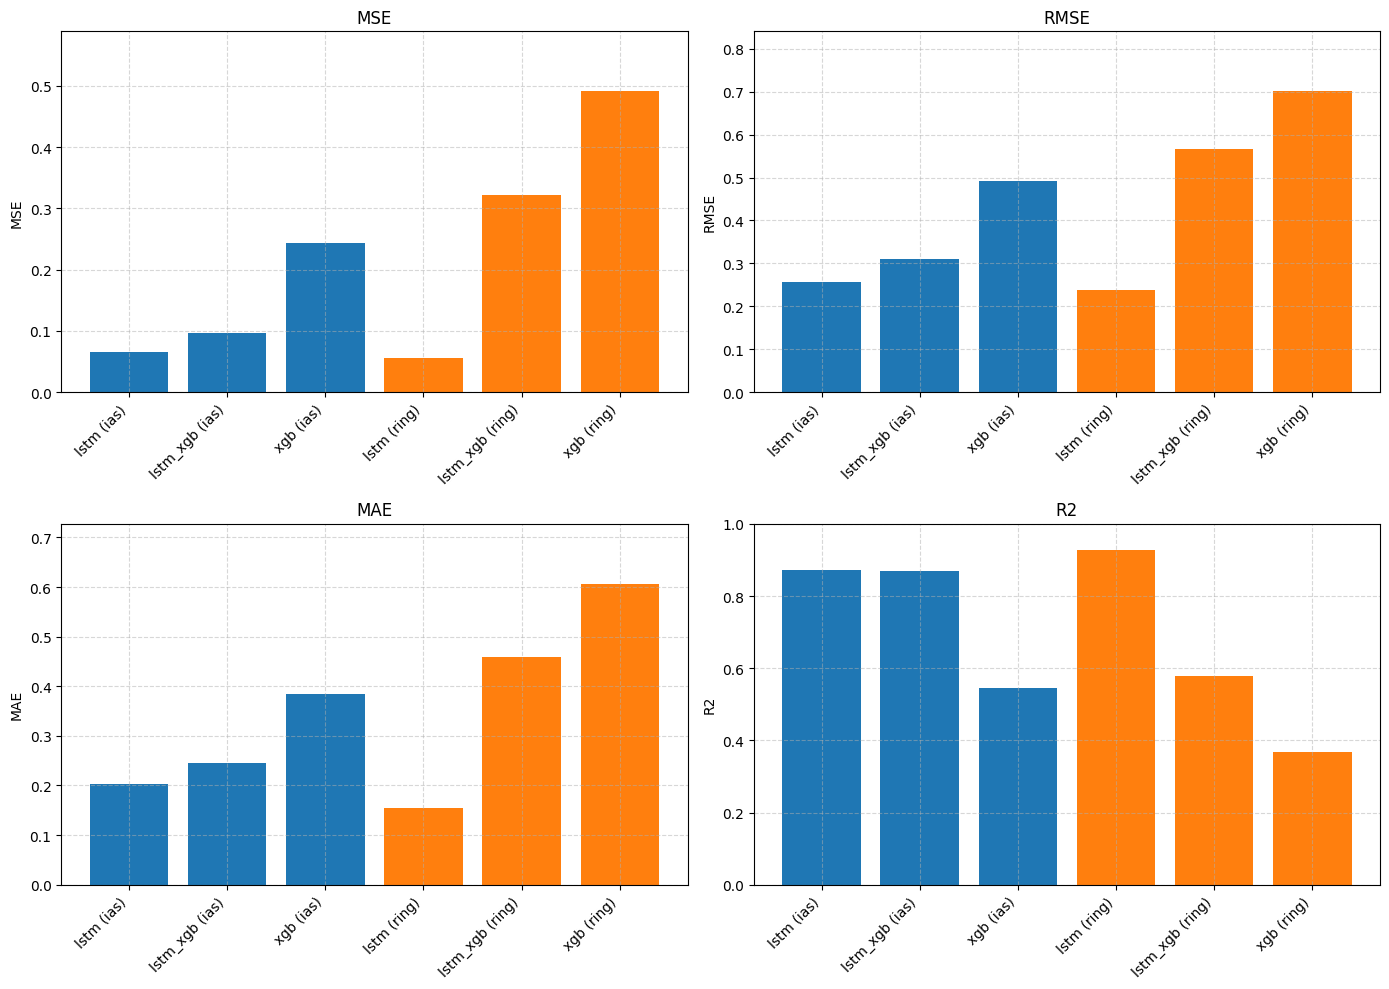

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 比較モデル
files = [
    "ias_lstm.csv",
    "ias_lstm_xgb.csv",
    "ias_xgb.csv",
    "ring_lstm.csv",
    "ring_lstm_xgb.csv",
    "ring_xgb.csv"
]

# resultsフォルダのパス
results_dir = "../results"

# 読み込みと整理用リスト
data = []

for f in files:
    filepath = os.path.join(results_dir, f)
    df = pd.read_csv(filepath)
    # ファイル名からセンサ名とモデル名を抽出（例：ias_xgb.csv -> ias, xgb）
    base = os.path.splitext(f)[0]
    sensor, model = base.split("_", 1)
    # それぞれの指標を辞書にして追加
    entry = {
        "Sensor": sensor,
        "Model": model,
        "MSE": df.loc[0, "MSE"],
        "RMSE": df.loc[0, "RMSE"],
        "MAE": df.loc[0, "MAE"],
        "R2": df.loc[0, "R2"]
    }
    data.append(entry)

# DataFrame化
df_results = pd.DataFrame(data)

# 数値出力（表形式で確認）
print("\n=== 各モデルの評価指標 ===")
print(df_results.to_string(index=False))

# 指標ごとにグラフ描画
metrics = ["MSE", "RMSE", "MAE", "R2"]

# 横軸のラベルとしてモデル名+センサ名を作る
labels = df_results["Model"] + " (" + df_results["Sensor"] + ")"

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    axs[i].bar(labels, df_results[metric], color=['#1f77b4' if 'ias' in s else '#ff7f0e' for s in df_results['Sensor']])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(np.arange(len(labels)))
    axs[i].set_xticklabels(labels, rotation=45, ha='right')
    if metric == "R2":
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(0, max(df_results[metric])*1.2)
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
